In [10]:
import sys

import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import scipy.stats as sp_stats
import torch
from torch import nn
from torch import optim

import tqdm.notebook as tqdm
from IPython.display import HTML

In [2]:
sys.path.append("../")

from bal import data, layers
from utils import animate_layer

In [3]:
class AdaptiveNet(nn.Module):
    def __init__(self, in_features, h_size, out_features):
        super(AdaptiveNet, self).__init__()
        self.fc1 = nn.Linear(in_features, h_size)
        self.ada1 = layers.AdaptiveSize(
            min_size=1,
            max_size=h_size,
            prior_loc=1,
            prior_scale=2,
            temperature=1.0
        )
        self.fc2 = nn.Linear(h_size, out_features)
        self.lik = layers.GaussianLikelihood(scale=0.1)
        self.bayesian_layers = [self.ada1]

    def forward(self, inp):
        out = nn.functional.relu(self.fc1(inp))
        out = self.ada1(out)
        out = self.fc2(out)
        return out

    def log_likelihood(self, xs, ys):
        params = self.forward(xs)
        logprobs = self.lik(params).log_prob(ys)
        return logprobs
    
    def kl_qp(self, n_samples=1, scale=1.0):
        kls = []
        for bl in self.bayesian_layers:
            samples_q = bl.posterior.rsample((n_samples,))
            kls.append(torch.mean(
                bl.posterior.log_prob(samples_q) - bl.prior.log_prob(samples_q)
            ))
        return scale * torch.sum(torch.stack(kls))
        

def geometric_discount(n, i):
    return 2 ** (n - i) / (2 ** n - 1)


def uniform_discount(n, _):
    return 1 / n

In [17]:
def run_step(xs_t, ys_t, opt, net, kl_scale=1.0):
    opt.zero_grad()
    ll = torch.mean(net.log_likelihood(xs_t, ys_t))
    kl = net.kl_qp(n_samples=100, scale=kl_scale)
    loss = kl - ll
    loss.backward()
    opt.step()
    stats = {
        "loss": loss.detach().numpy(),
#         "data_noise_scale": nn.functional.softplus(net.lik.var_spi_scale.detach()).numpy(),
        "layer_loc": net.ada1.var_loc.detach().numpy(),
        "layer_scale": nn.functional.softplus(net.ada1.var_spi_scale.detach()).numpy()
    }
    return stats

In [18]:
domain = (-2.0, 2.0)
xs, ys = data.generate_1d_regression(
    n_points=1000,
    domain=domain, 
    noise_std=0.1, 
    seed=7
)
xs_test = np.linspace(-4.0, 4.0, 500).reshape(-1, 1)

In [24]:
MAX_SIZE = 50
xs_t = torch.as_tensor(xs, dtype=torch.float32)
ys_t = torch.as_tensor(ys, dtype=torch.float32)
xs_test_t = torch.as_tensor(xs_test, dtype=torch.float32)
net = AdaptiveNet(
    in_features=1,
    h_size=MAX_SIZE,
    out_features=1
)
opt = optim.Adam(net.parameters(), lr=2e-4)

In [25]:
n_epochs = 1000
batch_size = 1000
pbar = tqdm.tqdm(range(n_epochs))
train_history = {"layer_loc": [], "layer_scale": [], "preds": []}
for i in pbar:
    for j, (x_t, y_t) in enumerate(data.batch_generator(xs_t, ys_t, batch_size, shuffle=True)):
        kl_scale = geometric_discount(len(xs_t) // batch_size, j+1)
        stats = run_step(x_t, y_t, opt, net, kl_scale)
    if i % 1000 == 0:
        pbar.set_description_str(
            f"loss: {stats['loss']:4.2f}, " 
            f"l_loc: {stats['layer_loc']:4.2f}, " 
            f"l_scale: {stats['layer_scale']:4.2f}"
        )
        train_history["layer_loc"].append(stats["layer_loc"])
        train_history["layer_scale"].append(stats["layer_scale"])
        train_history["preds"].append(net(xs_test_t).detach().numpy().squeeze())

for k, v in train_history.items():
    train_history[k] = np.asarray(v)

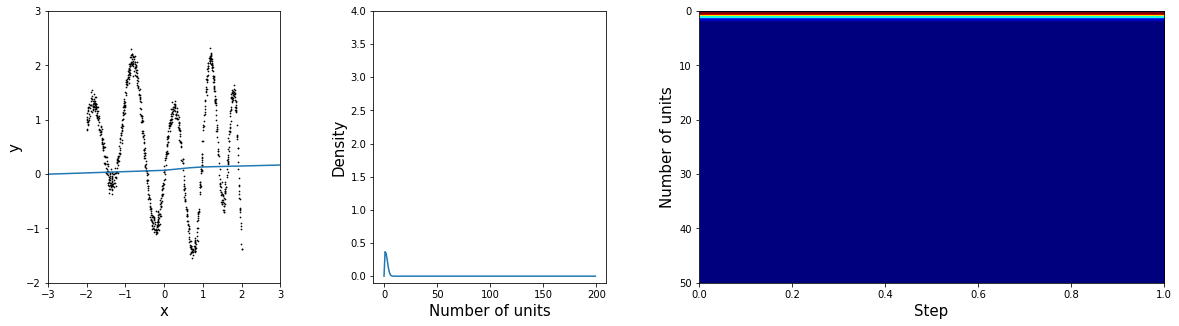

In [26]:
ani = animate_layer(
    data=(xs, ys), 
    predictions=(xs_test, train_history["preds"]), 
    layer_stats=(train_history["layer_loc"], train_history["layer_scale"]), 
    max_size=MAX_SIZE, 
    output_path="../animation"
)
HTML(ani.to_html5_video())

In [28]:
train_history["layer_loc"]

array([1.1949111], dtype=float32)